In [1]:
import os
user = "ruslanahmadov" 
key = "faf7fdfcecbe76c653003ce3988f59a3"
if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d puneet6060/intel-image-classification

 99% 344M/346M [00:02<00:00, 155MB/s]
100% 346M/346M [00:02<00:00, 141MB/s]


In [2]:
!unzip "/content/intel-image-classification.zip"

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [3]:
import torch
from torch import nn
import pathlib
from torch.utils.data import DataLoader
from torchvision import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
transformtrain = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
transformtest = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

In [6]:
trainds = datasets.ImageFolder('/content/seg_train/seg_train', transform=transformtrain)
testds = datasets.ImageFolder('/content/seg_test/seg_test', transform=transformtest)

In [7]:
trainloader = DataLoader(trainds, batch_size=256, shuffle=True)
testloader = DataLoader(testds, batch_size=64, shuffle=False)

In [8]:
model = models.vgg19(pretrained=True).to(device)
for param in model.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [132]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [133]:
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.00001)

In [134]:
trainlosses = []
testlosses = []
for e in range(3):
    trainloss = 0
    traintotal = 0
    trainsuccessful = 0
    for traininput, trainlabel in trainloader:
        traininputs, trainlabels = traininput.to(device), trainlabel.to(device)
        optimizer.zero_grad()
        trainpredictions = model(traininputs)
        _, trainpredict = torch.max(trainpredictions.data, 1)
        loss = criterion(trainpredictions, trainlabels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()
        traintotal += trainlabels.size(0)
        trainsuccessful += (trainpredict == trainlabels).sum().item()
    else:
        testloss = 0
        testtotal = 0
        testsuccessful = 0
        with torch.no_grad():
            for testinput, testlabel in testloader:
                testinputs, testlabels = testinput.to(device), testlabel.to(device)
                testpredictions = model(testinputs)
                _, testpredict = torch.max(testpredictions.data, 1)
                tloss = criterion(testpredictions, testlabels)
                testloss += tloss.item()
                testtotal += testlabels.size(0)
                testsuccessful += (testpredict == testlabels).sum().item()
        trainlosses.append(trainloss/len(trainloader))
        testlosses.append(testloss/len(testloader))
        print('Train Accuracy %{:.2f}'.format(100*trainsuccessful/traintotal))
        print('Test Accuracy %{:.2f}'.format(100*testsuccessful/testtotal))

Train Accuracy %73.69
Test Accuracy %86.37
Train Accuracy %88.30
Test Accuracy %88.70
Train Accuracy %89.51
Test Accuracy %88.97


In [135]:
import matplotlib.pyplot as plt

In [136]:
from PIL import Image
import numpy as np

In [152]:
img = Image.open('/content/seg_pred/seg_pred/10012.jpg')

In [153]:
nimg = np.array(img)

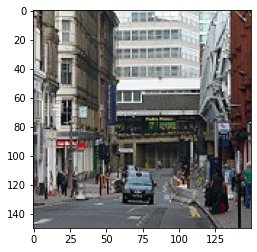

In [154]:
plt.imshow(nimg)

In [155]:
pimg = transformtest(img).unsqueeze(0).to(device)

In [156]:
prediction = model(pimg)

In [157]:
_, tpredict = torch.max(prediction.data, 1)

In [158]:
classes[tpredict[0].item()]

'street'